# Purpose
The purpose of this notebook is to load the data source and build a vector store.

# Data Source
The reddit financial dataset from HuggingFace will be used as the data source for this project.  Information available [here](https://huggingface.co/datasets/winddude/reddit_finance_43_250k). 

In [6]:
from datasets import load_dataset

df_data = (
    load_dataset("winddude/reddit_finance_43_250k", split="train")
    .to_pandas()
    .sort_values(by="combined_score", ascending=False)
)

df_data["text"] = df_data["title"] + "/n/n" + df_data["selftext"] + "/n/n" + df_data["body"]
df_data["text_len"] = df_data.text.str.len()

## EDA

It looks like some of the text strings are very long, though the majority are <2,000 characters.  For this simple example, I don't want to spend extra effort on splitting strategies or a summarization task on the longer texts, so I'll simply split any text with 1,000 characters or more.  In order to keep the database to a manageble size, I'll choose the "best" 5,000 options as scored by `combined_score`.  I'll keep the following columns as metadata:
- id
- title
- subreddit

Index(['id', 'title', 'selftext', 'z_score', 'normalized_score', 'subreddit',
       'body', 'comment_normalized_score', 'combined_score', 'text',
       'text_len'],
      dtype='object')


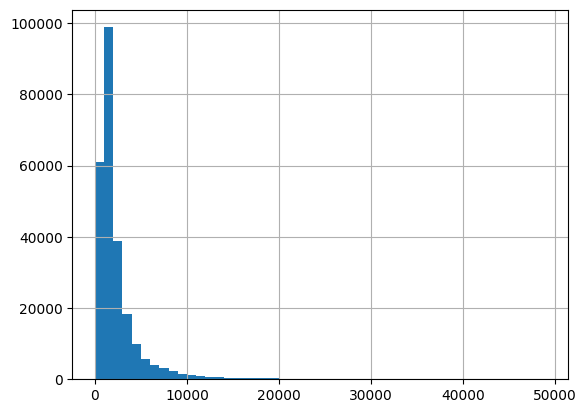

In [8]:
df_data["text_len"].hist(bins = range(0, 50000, 1000))
print(df_data.columns)

In [9]:
df_data = (
    df_data
    .iloc[0:5000]
    .loc[:,["id", "title", "subreddit", "text"]]
)

# Vector Database

## Generate Documents
Langchain provides many different [document loaders](https://integrations.langchain.com).  I'll use the `DataFrameLoader` here, which needs to be provided with the column which contains the page content and any remaining columns will be attached as metadata.

In [10]:
from langchain.document_loaders import DataFrameLoader

loader = DataFrameLoader(df_data, page_content_column="text")
docs_full = loader.load()

## Split Documents
As described above, I'll split any text longer than 1000 chr.

In [12]:
from langchain.text_splitter import CharacterTextSplitter

# split pages into max 1000 chr chunks
text_splitter = CharacterTextSplitter(        
    separator = "\n\n",
    chunk_size = 1000,
    chunk_overlap  = 200,
    length_function = len,
    is_separator_regex = False,
)
docs = text_splitter.split_documents(docs_full)

Created a chunk of size 1608, which is longer than the specified 1000
Created a chunk of size 3342, which is longer than the specified 1000
Created a chunk of size 1050, which is longer than the specified 1000
Created a chunk of size 1660, which is longer than the specified 1000
Created a chunk of size 1288, which is longer than the specified 1000
Created a chunk of size 1066, which is longer than the specified 1000
Created a chunk of size 1182, which is longer than the specified 1000
Created a chunk of size 1066, which is longer than the specified 1000
Created a chunk of size 1087, which is longer than the specified 1000
Created a chunk of size 1066, which is longer than the specified 1000
Created a chunk of size 1176, which is longer than the specified 1000
Created a chunk of size 1120, which is longer than the specified 1000
Created a chunk of size 1605, which is longer than the specified 1000
Created a chunk of size 1012, which is longer than the specified 1000
Created a chunk of s

## Embed and Store
Now I'll embed using OpenAI embeddings and store in [Pinecone](https://www.pinecone.io).

In [14]:
import os
import toml
import pinecone
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Pinecone

os.environ["PINECONE_API_KEY"] = toml.load("secrets.toml")["PINECONE_API_KEY"]
os.environ["OPENAI_API_KEY"] = toml.load("secrets.toml")["OPENAI_API_TOKEN"]

index_name = "reddit-finance"
pinecone.init(environment=toml.load("secrets.toml")["PINECONE_ENV"])

if index_name not in pinecone.list_indexes():
    pinecone.create_index(name=index_name, dimension=1536, metric="cosine")
pinecone_index = pinecone.Index(index_name)

embeddings = OpenAIEmbeddings()
vectorstore = Pinecone.from_documents(
    docs, embeddings, index_name=index_name
)

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-embedding-ada-002 in organization org-8NK4TlJomwX2wpzx2hRoGfhM on tokens per min. Limit: 1000000 / min. Current: 820652 / min. Contact us through our help center at help.openai.com if you continue to have issues..
